In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# 2차원 입력 면 모델

## 데이터 불러오기

**Input data**: 2-dimension $\textbf{x} = (x_0,x_1)$
- For instance, (Sex, Height), (Sex, Diameter), (Height, Whole weight) ...

**Target data**: $\textbf{t} = (\text{Rings})$

$ \rightarrow \\
    \textbf{x} = \begin{bmatrix}
        x_{00} & x_{01} \\
        x_{10} & x_{11} \\
        \vdots & \vdots \\
        x_{N-1,0} & x_{N-1, 1}
        \end{bmatrix}, \qquad
    \textbf{t} = \begin{bmatrix}
        t_{0} \\
        x_{1} \\
        \vdots \\
        x_{N-1}
        \end{bmatrix}
$

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def load_abalone_dataset():
    df = pd.read_csv('./abalone.csv')
    df = df.drop(df.loc[df['Height']>0.3].index, axis=0)
    df = pd.get_dummies(df) # One-Hot Encoding
    
    X0, X1, T = df['Length'], df['Diameter'], df['Rings']
    return X0, X1, T

if __name__=="__main__":
    X0, X1, T = load_abalone_dataset()
    df_2D = pd.concat([X0, X1, T], axis=1)
    print(df_2D.head(10))

   Length  Diameter  Rings
0   0.455     0.365     15
1   0.350     0.265      7
2   0.530     0.420      9
3   0.440     0.365     10
4   0.330     0.255      7
5   0.425     0.300      8
6   0.530     0.415     20
7   0.545     0.425     16
8   0.475     0.370      9
9   0.550     0.440     19


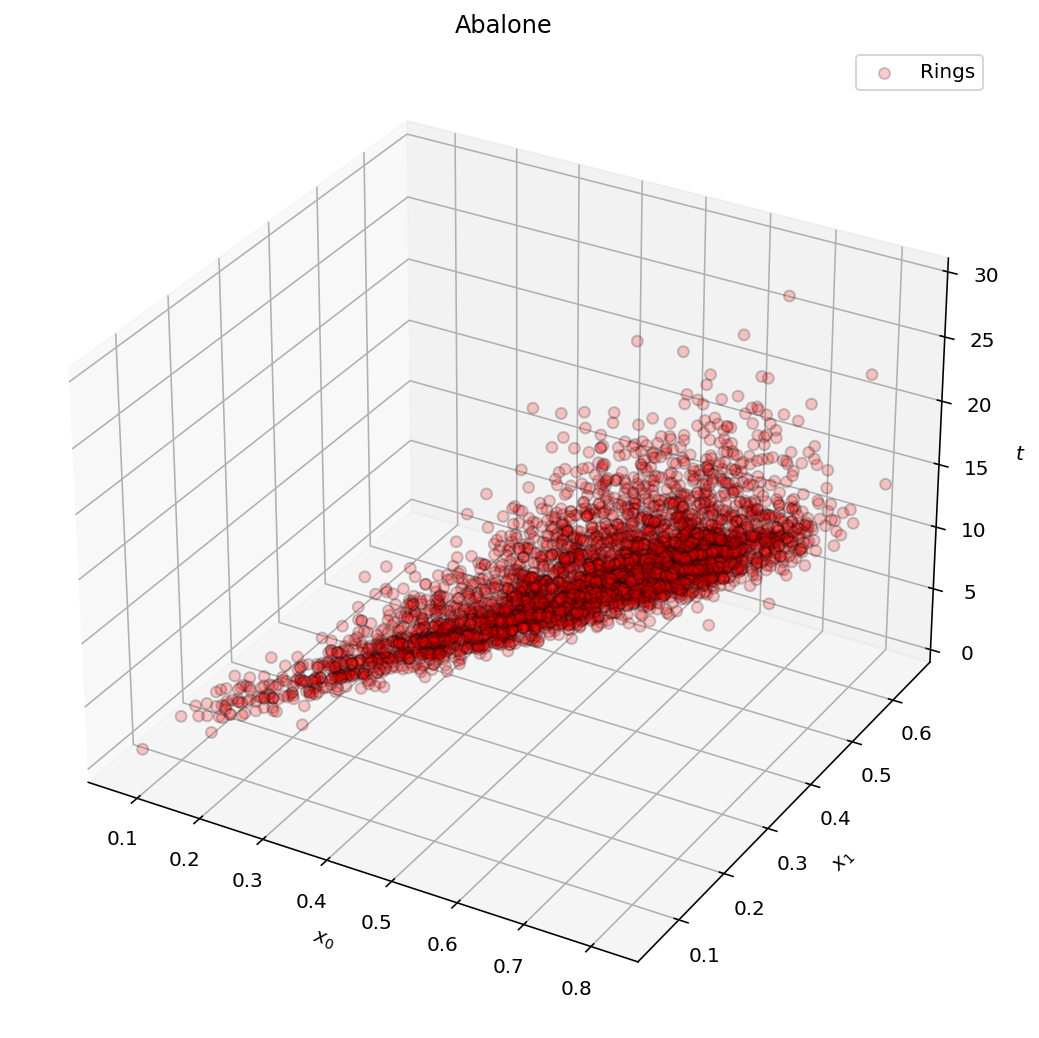

In [5]:
def show_data2(ax, x0, x1, t):
    ax.scatter(x0, x1, t,
               facecolor='red',
               edgecolor='k',
               s = 30, # size
               alpha = 0.2,
               label = "Rings")

if __name__=="__main__":
    plt.figure(figsize=(9,9))
    ax = plt.subplot(1, 1, 1, projection='3d')
    show_data2(ax, X0, X1, T)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$t$')
    ax.set_title("Abalone")
    ax.legend()
    
    plt.show()

## 면 모델
(Height, Diameter) data can be expressed as 'Plane' model.  
$ y(x_0, x_1) = w_0x_1 + w_1x_1 + w_2 $

$
\rightarrow \\
\textbf{y = w}^T\textbf{x} \qquad where \qquad \textbf{x} = 
    \begin{bmatrix} x_0 \\ x_1 \\ 1 \end{bmatrix}, \qquad \textbf{w} = \begin{bmatrix}w_0 \\ w_1 \\ w_2 \end{bmatrix}
$

SD=8.584cm


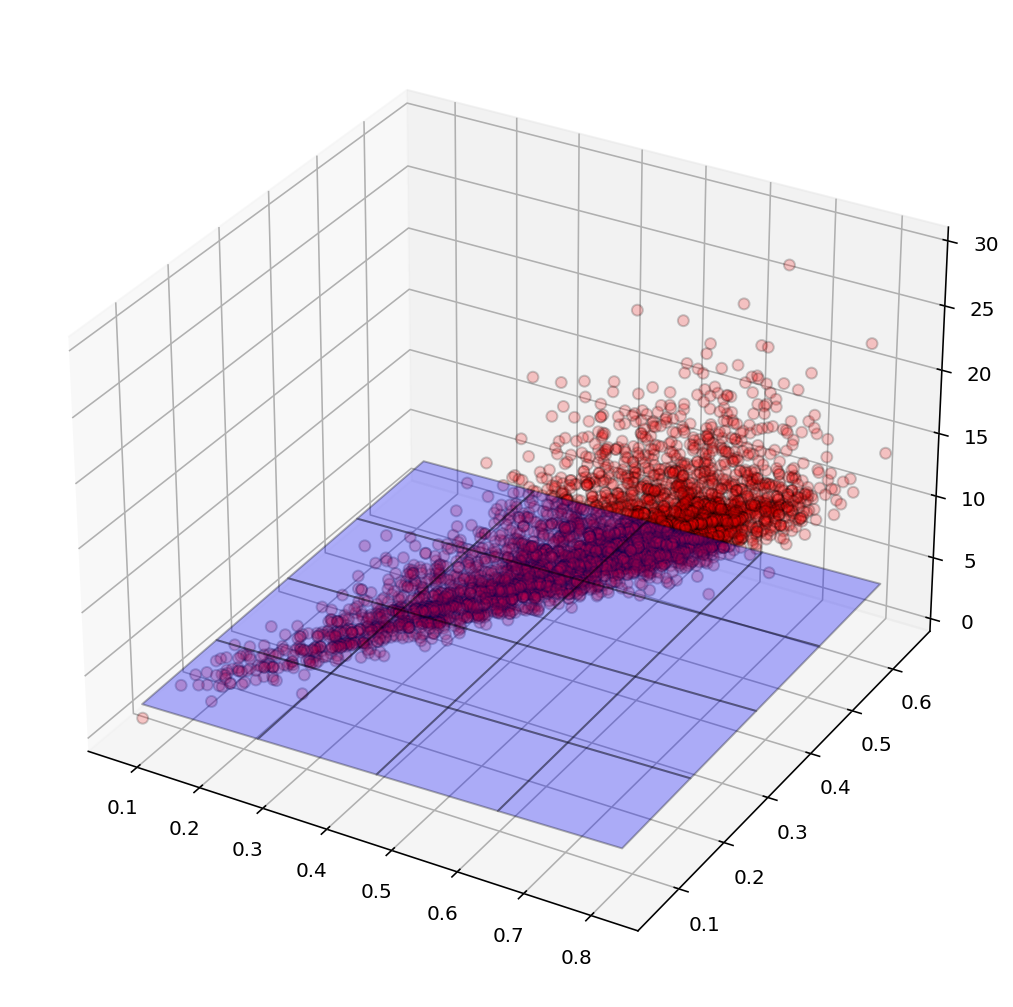

In [6]:
def show_plane(ax, x0, x1, w):
    x0 = np.linspace(min(x0), max(x0), 5)
    x1 = np.linspace(min(x1), max(x1), 5)
    xx0, xx1 = np.meshgrid(x0, x1)
    y = w[0]*xx0 + w[1]+xx1 + w[2]
    ax.plot_surface(xx0, xx1, y, rstride=1, cstride=1, alpha=0.3, color='blue', edgecolor='k')
    
def mse_plane(x0, x1, t, w):
    y = w[0]*x0 + w[1]*x1 + w[2]
    mse = np.mean((y-t)**2)
    return mse

if __name__=="__main__":
    plt.figure(figsize=(9, 9))
    ax = plt.subplot(1,1,1, projection='3d')
    W = [1, 1, 1] # test
    show_plane(ax, X0, X1, W)
    show_data2(ax, X0, X1, T)
    mse = mse_plane(X0, X1, T, W)
    print(f"SD={np.sqrt(mse):.3f}cm")

## Gradient Descent
- gradient of $J$
- $
\nabla_W J = \left[ \cfrac {\partial J}{\partial w_0}, \cfrac {\partial J}{\partial w_1}, \cfrac {\partial J}{\partial w_2} \right]^T
$

### $W$ **Update**
- $\textbf{w}(t+1) = \textbf{w}(t) - \alpha \nabla_{\textbf{w}}J| _{\textbf{w}(t)}$

### $W$ Update (J Partial Derivative)
- $w_0(t+1) = w_0(t) - \alpha \cfrac{2}{N}\displaystyle\sum_{n=0}^{N-1}(y_n-t_n)x_{n0}$
- $w_1(t+1) = w_1(t) - \alpha \cfrac{2}{N}\displaystyle\sum_{n=0}^{N-1}(y_n-t_n)x_{n1}$
- $w_2(t+1) = w_2(t) - \alpha \cfrac{2}{N}\displaystyle\sum_{n=0}^{N-1}(y_n-t_n)$

In [7]:
def mse_plane(x0, x1, t, w):
    y = w[0]*x0 + w[1]*x1 + w[2]
    mse = np.mean((y-t)**2)
    return mse

def dmse_plane(x0, x1, t, w):
    y = w[0]*x0 + w[1]*x1 + w[2]
    d_w0 = 2*np.mean((y-t)*x0)
    d_w1 = 2*np.mean((y-t)*x1)
    d_w2 = 2*np.mean(y-t)
    return [d_w0, d_w1, d_w2]

In [8]:
def fit_plane_num(x0: list, x1: list, t: list, w_init: list) -> tuple:
    alpha: float = 0.001
    i_max: int = 1000000
    eps: float = 0.01
    w_i = np.zeros([i_max, 3])
    w_i[0, :] = w_init
    print(f"Initial MSE = {np.round(mse_plane(x0, x1, t, w_i[0, :]), 3)}, W = {np.round(w_i[0, :], 3)} ")
    
    for i in range(1, i_max):
        mse = mse_plane(x0, x1, t, w_i[i-1])
        dmse = dmse_plane(x0, x1, t, w_i[i-1])
        w_i[i,0] = w_i[i-1, 0]-alpha*dmse[0]
        w_i[i,1] = w_i[i-1, 1]-alpha*dmse[1]
        w_i[i,2] = w_i[i-1, 2]-alpha*dmse[2]
        if i % 10000 == 0:
            print(f"Iter = {i}, MSE = {np.round(mse,3)}, W = {np.round(w_i[i], 3)}, dMSE = {np.round(dmse, 3)}")
        
        if max(np.absolute(dmse)) < eps:
            break
    
    w = [w_i[i, 0], w_i[i, 1], w_i[i, 2]]
    w_i = w_i[:i,:]
    return w, dmse, w_i

In [9]:
# Main------------
W_init = [1, 1, 1]
X0, X1, T = load_abalone_dataset()
W, dMSE, W_history = fit_plane_num(X0, X1, T, W_init)

print('반복 횟수 {0}'.format(W_history.shape[0]))
print('W=[{0:.6f}, {1:.6f}, {2:.6f}]'.format(W[0], W[1], W[2]))
print('dMSE=[{0:.6f}, {1:.6f}, {2:.6f}]'.format(dMSE[0], dMSE[1], dMSE[2]))
print('MSE={0:.6f}'.format(mse_plane(X0, X1, T, W)))

Initial MSE = 73.683, W = [1. 1. 1.] 
Iter = 10000, MSE = 7.605, W = [5.333 4.592 5.32 ], dMSE = [-0.114 -0.109  0.106]
Iter = 20000, MSE = 7.342, W = [6.294 5.528 4.42 ], dMSE = [-0.08  -0.08   0.076]
Iter = 30000, MSE = 7.206, W = [6.965 6.219 3.775], dMSE = [-0.056 -0.059  0.054]
Iter = 40000, MSE = 7.136, W = [7.43  6.736 3.314], dMSE = [-0.038 -0.045  0.039]
Iter = 50000, MSE = 7.099, W = [7.746 7.126 2.983], dMSE = [-0.026 -0.034  0.028]
Iter = 60000, MSE = 7.08, W = [7.956 7.426 2.747], dMSE = [-0.017 -0.026  0.02 ]
Iter = 70000, MSE = 7.07, W = [8.089 7.661 2.578], dMSE = [-0.01  -0.021  0.014]
Iter = 80000, MSE = 7.064, W = [8.168 7.85  2.458], dMSE = [-0.006 -0.017  0.01 ]
Iter = 90000, MSE = 7.061, W = [8.209 8.006 2.372], dMSE = [-0.002 -0.014  0.007]
Iter = 100000, MSE = 7.059, W = [8.221 8.137 2.31 ], dMSE = [-0.    -0.012  0.005]
Iter = 110000, MSE = 7.057, W = [8.213 8.251 2.267], dMSE = [ 0.002 -0.011  0.004]
반복 횟수 116638
W=[8.199958, 8.320013, 2.245705]
dMSE=[0.002401

임의의 W에 대한 SD=8.584cm
경사하강법에 의한 SD=2.656cm


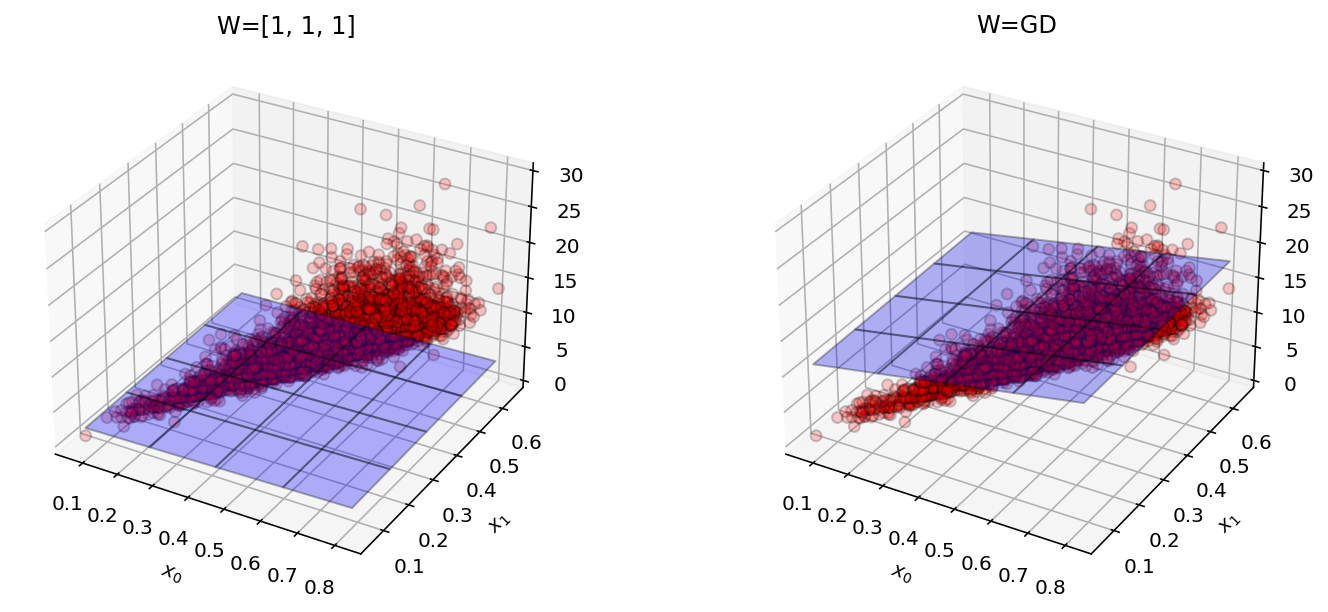

In [10]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1, 2, 1, projection ='3d')
plt.title(f"W=[{W_init[0]}, {W_init[1]}, {W_init[2]}]")
show_plane(ax, X0, X1, W_init)
show_data2(ax, X0, X1, T)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
mse = mse_plane(X0, X1, T, W_init)
print("임의의 W에 대한 SD={0:.3f}cm".format(np.sqrt(mse)))

ax = plt.subplot(1, 2, 2, projection ='3d')
plt.title(f"W=GD")
show_plane(ax, X0, X1, W)
show_data2(ax, X0, X1, T)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
mse2 = mse_plane(X0, X1, T, W)
print("경사하강법에 의한 SD={0:.3f}cm".format(np.sqrt(mse2)))

plt.show()

# D차원 입력 면 모델

In [11]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBacked.figure_format = 'retina'

def load_abalone_dataset():
    df = pd.read_csv('./abalone.csv')
    df = df.drop(df.loc[df['Height']>0.3].index, axis=0)
    df = pd.get_dummies(df)
    X = df.drop(['Rings'], axis=1)
    T = df['Rings']
    return X, T

In [47]:
def mse_hyperplane(x, t, w):
    y = 0
    for i in range(x.shape[1]):
        y += w[i]*x[:,i]
    y += w[x.shape[1]]
    
    mse = np.mean((y-t)**2)
    return mse
        
def dmse_hyperplane(x, t, w):
    y = 0
    dmse = list()
    for i in range(x.shape[1]):
        y += w[i]*x[:,i]
    y += w[x.shape[1]]
    for i in range(x.shape[1]):
        dmse.append(2*np.mean((y-t)*x[:,i]))
    dmse.append(2*np.mean((y-t)))
    return dmse

In [48]:
""" 
def dmse_hyperplane(x, t, w):
    y = 0
    dmse = np.zeros(w.shape[1])
    for i in range(x.shape[1]):
        y += w[i]*x[:, i]
    y += w[x.shape[1]+1]
    
    for i in range(x.shape[1]):
        dmse[:] = 2*np.mean((y-t)*x[:,i])
    dmse[-1] = 2*np.mean(y-t)
    return dmse
"""

' \ndef dmse_hyperplane(x, t, w):\n    y = 0\n    dmse = np.zeros(w.shape[1])\n    for i in range(x.shape[1]):\n        y += w[i]*x[:, i]\n    y += w[x.shape[1]+1]\n    \n    for i in range(x.shape[1]):\n        dmse[:] = 2*np.mean((y-t)*x[:,i])\n    dmse[-1] = 2*np.mean(y-t)\n    return dmse\n'

In [64]:
def fit_hyperplane_num(x, t, w_init):
    alpha = 0.001
    i_max = 1000000
    eps = 0.01
    w_i = np.zeros([i_max, w_init.shape[0]])
    w_i[0, :] = w_init
    print(f"Initial MSE = {np.round(mse_hyperplane(x, t, w_i[0, :]), 3)}, \nW = {np.round(w_i[0, :], 3)} ")

    for i in range(1, i_max):
        mse = mse_hyperplane(x, t, w_i[i-1])
        dmse = dmse_hyperplane(x, t, w_i[i-1])
        for j in range(w_init.shape[0]):
            w_i[i,j] = w_i[i-1, j]-alpha*dmse[j]
        
        if i % 10000 == 0:
            print(f"Iter = {i}, MSE = {np.round(mse,3)}, W = {np.round(w_i[i], 3)}, dMSE = {np.round(dmse, 3)}")
        
        if max(np.absolute(dmse)) < eps:
            break
            
    w = [w for w in w_i[i, :]]
    w_i = w_i[:i, :]
    return w, dmse, w_i

In [65]:
# Main-----------
X, T = load_abalone_dataset()
X = X.to_numpy()
W_init = np.random.randn(X.shape[1]+1)

W, dMSE, W_History = fit_hyperplane_num(X, T, W_init)

print(f'반복 횟수: {W_History.shape[0]}\nW: {W}\ndMSE: {dMSE}\nMSE: {mse_hyperplane(X, T, W)}')

Initial MSE = 97.622, 
W = [-0.246  0.039 -0.251 -1.299  1.156  0.446  0.32  -0.18   1.078  0.091
  1.107] 
Iter = 10000, MSE = 6.871, W = [1.821 1.762 0.498 1.145 0.73  0.827 1.991 2.068 0.759 1.84  4.786], dMSE = [-0.026 -0.031 -0.026  0.01   0.145  0.018 -0.088 -0.016  0.018 -0.014
 -0.012]
Iter = 20000, MSE = 6.594, W = [ 2.052  2.049  0.751  1.224 -0.58   0.681  2.882  2.096  0.667  1.87
  4.753], dMSE = [-0.021 -0.027 -0.025 -0.017  0.122  0.012 -0.088  0.004  0.005  0.002
  0.011]
Iter = 30000, MSE = 6.362, W = [ 2.255  2.31   0.99   1.415 -1.742  0.562  3.734  2.04   0.634  1.833
  4.627], dMSE = [-0.019 -0.025 -0.023 -0.02   0.111  0.012 -0.082  0.006  0.003  0.004
  0.013]
Iter = 40000, MSE = 6.162, W = [ 2.439  2.552  1.216  1.611 -2.815  0.446  4.527  1.978  0.61   1.79
  4.498], dMSE = [-0.018 -0.023 -0.022 -0.019  0.103  0.012 -0.076  0.006  0.002  0.004
  0.013]
Iter = 50000, MSE = 5.99, W = [ 2.606  2.775  1.432  1.797 -3.811  0.331  5.261  1.92   0.589  1.75
  4.377], 